### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

# Packages

In [21]:
from os.path import isdir
from os import mkdir

env = 'colab'  # 'pc', 'colab'
git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Semi-Supervised-Labelling/final_preparation/'
experiment = 'Exp1/'

save_dir = ''
if env == 'pc':
    save_dir = f'C:/Users/79137/Pasha/2. UNIPD/Semester 2/Optimization for Data Science/Homeworks/HW 1/Semi-Supervised-Labelling/'
elif env == 'colab':
    save_dir = f'/content/drive/MyDrive/UNIPD/ODS/HW1/'

full_dir = f'{save_dir}{experiment}'

assert(isdir(save_dir))

if not isdir(full_dir):
    mkdir(full_dir)

assert(isdir(full_dir))


In [22]:
%%capture

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
           'BCGDSolver.py',
           'DataProperties.py',
           'GradientDescentSolver.py',
           'GradientSolver.py',
           'Utils.py'  
    ]

    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

In [23]:
from sklearn.datasets import make_blobs
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt

In [24]:
import Utils
import GradientSolver
import GradientDescentSolver
import DataProperties
import BCGDSolver
import importlib

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        Utils,
        GradientSolver,
        GradientDescentSolver,
        DataProperties,
        BCGDSolver
    ]
)

from Utils import *
from GradientSolver import GradientSolver
from GradientDescentSolver import GradientDescentSolver
from DataProperties import DataProperties
from BCGDSolver import BCGDSolver

# Data preparation

In [25]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

np.random.seed(numpy_seed)

Data shape: X: (200, 2), Y: (200,)


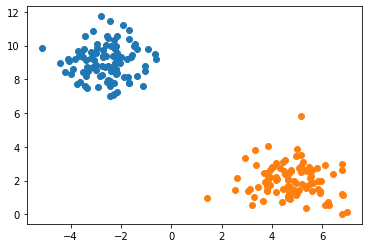

In [26]:
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)

def euclidian_similarity(Xi, Xj):
    return 1 / (norm(Xi - Xj) + 0.001)

weights = calc_weight_matrix(X, weight_func = euclidian_similarity)


Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')
plot_clusters(X, Y)

## Unlabel subset and visualize

Found 100 instances of object 0.0
We have to delabel 95 instances
Found 100 instances of object 1.0
We have to delabel 95 instances

    We have 190 unlabeled data
    Out of 200
    


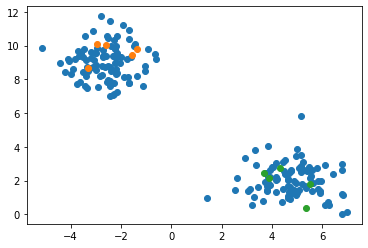

In [27]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

plot_clusters(X, Y_delabeled)

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [28]:
import collections
class_stats = collections.Counter(Y_delabeled)
assert(len(class_stats.keys()) == 3)  # 2 labeled classes and 1 unlabeled

# Gradient descent

In [29]:
# solver = GradientDescentSolver(
#     similarity_func = None, # euclidian_similarity,
#     lr_strategy = 'lr_constant',  # search for alpha_k
#     learning_rate = 0.001
# )

In [30]:
# Y_preds_GD = solver.solve(
#     X, 
#     Y_delabeled, 
#     iter_limit = 10, 
#     delta_loss_limit = 0.008, 
#     stop_loss = 150,
#     weight_matrix = weights
# )

Iteration: 0, Loss: 248.28414123752782, delta loss: 248.28414123752782
Iteration: 1, Loss: 243.6499183160233, delta loss: 4.6342229215045165
Iteration: 2, Loss: 239.81321314089578, delta loss: 3.83670517512752
Iteration: 3, Loss: 236.5656858048136, delta loss: 3.247527336082186
Iteration: 4, Loss: 233.7695256864917, delta loss: 2.796160118321893
Iteration: 5, Loss: 231.33076530099513, delta loss: 2.438760385496579
Iteration: 6, Loss: 229.1831921005058, delta loss: 2.147573200489319
Iteration: 7, Loss: 227.27853529295055, delta loss: 1.9046568075552557
Iteration: 8, Loss: 225.5804009938172, delta loss: 1.6981342991333577
Iteration: 9, Loss: 224.06046806103103, delta loss: 1.519932932786162




Accuracy: 1.0


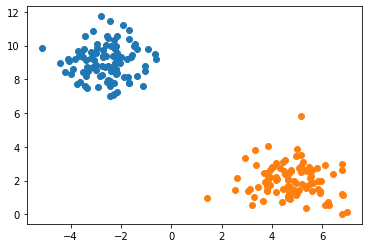

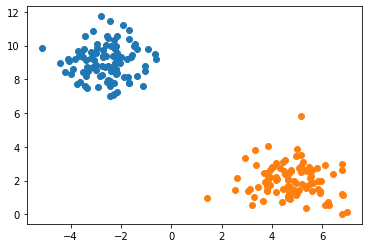

In [31]:
# plot_clusters(X, Y)
# plot_clusters(X, Y_preds_GD)
# print(f'Accuracy: {accuracy_score(Y, Y_preds_GD)}')

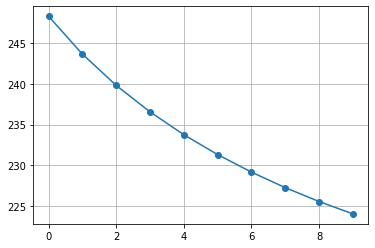

In [32]:
# plt.plot(solver.losses, marker = 'o')
# plt.grid()

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [ ]:
# random_solver = BCGDSolver(
#     lr_strategy = 'lr_constant',
#     learning_rate = 0.001,
#     similarity_func = None,

#     bcgd_strategy = 'random permutation',
# )

In [ ]:
# Y_preds_BCGD_permutation = random_solver.solve(
#     X, 
#     Y_delabeled, 
#     iter_limit = 10, 
#     delta_loss_limit = 0.008, 
#     stop_loss= 2174,
#     weight_matrix = weights
# )

In [ ]:
# plot_clusters(X, Y)
# plot_clusters(X, Y_preds_BCGD_permutation)
# print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_permutation)}')

In [ ]:
# plt.plot(random_solver.losses, marker = 'o')
# plt.grid()

## BCGD random sampling

In [ ]:
# BCGD_RS_solver = BCGDSolver(
#     lr_strategy = 'lr_constant',
#     learning_rate = 0.00015,
#     similarity_func = None,

#     bcgd_strategy = 'random sampling'
# )

In [ ]:
# Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
#     X = X, 
#     Y = Y_delabeled, 
#     iter_limit = 100,
#     delta_loss_limit = 0.0,
#     stop_loss= 2380,
#     weight_matrix = weights
# )

In [ ]:
# plot_clusters(
#     X, Y_preds_BCGD_sampling
# )
# print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_sampling)}')

In [ ]:
# plt.plot(BCGD_RS_solver.losses)
# plt.grid()

## BCGD cyclic

In [ ]:
# BCGD_cyclic_solver = BCGDSolver(
#     lr_strategy = 'lr_constant',
#     learning_rate = 0.001,
#     similarity_func = None,

#     bcgd_strategy = 'cyclic'
# )

In [ ]:
# Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
#     X,
#     Y_delabeled, 
#     iter_limit = 10, 
#     delta_loss_limit = 0.0001,
#     stop_loss = 2300,
#     weight_matrix = weights
# )

In [ ]:
# print(f'Accuracy: {accuracy_score(Y_preds_BCGD_cyclic, Y)}')
# plot_clusters(
#     X, Y_preds_BCGD_cyclic
# )

In [ ]:
# plt.plot(BCGD_cyclic_solver.losses, marker = 'o')
# plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [33]:
learning_rate_strategy = 'lr_constant'
simil_func = None  # No feature yet
lr = 0.001

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

solvers = {
    'GD': gd_solver,
    'BCGD permutation': bcgd_permut_solver,
    'BCGD cyclic': bcgd_cyclic_solver,
    'BCGD sampling': bcgd_sampling_solver,
}

In [34]:
def compare_models(solvers_dict, X, Y_delabeled, iters_limit, delta_loss_limit, stop_loss, weights_matrix):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times_total = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            iter_limit = iters_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss= stop_loss,
            weight_matrix = weights_matrix
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times_total[model_name] = end - start
    

    return predictions, losses, n_iterations, cpu_times_total

In [35]:
iters_limit = 15
delta_loss_limit = 0.0001
stop_loss= 150  # 4000


preds, losses, n_iters, cpu_times_total = compare_models(
        solvers,
        X,
        Y_delabeled,
        iters_limit = iters_limit,
        delta_loss_limit = delta_loss_limit,
        stop_loss = stop_loss,
        weights_matrix =  weights
    )

accuracies = {name: accuracy_score(preds[name], Y) for name in solvers.keys()}
cpu_times = {name: solver.cpu_times for name, solver in solvers.items()}

Iteration: 0, Loss: 248.28414123752782, delta loss: 248.28414123752782
Iteration: 1, Loss: 243.6499183160233, delta loss: 4.6342229215045165
Iteration: 2, Loss: 239.81321314089578, delta loss: 3.83670517512752
Iteration: 3, Loss: 236.5656858048136, delta loss: 3.247527336082186
Iteration: 4, Loss: 233.7695256864917, delta loss: 2.796160118321893
Iteration: 5, Loss: 231.33076530099513, delta loss: 2.438760385496579
Iteration: 6, Loss: 229.1831921005058, delta loss: 2.147573200489319
Iteration: 7, Loss: 227.27853529295055, delta loss: 1.9046568075552557
Iteration: 8, Loss: 225.5804009938172, delta loss: 1.6981342991333577
Iteration: 9, Loss: 224.06046806103103, delta loss: 1.519932932786162
Iteration: 10, Loss: 222.69606180958328, delta loss: 1.3644062514477469
Iteration: 11, Loss: 221.4685772869031, delta loss: 1.2274845226801858
Iteration: 12, Loss: 220.36243304707807, delta loss: 1.1061442398250279
Iteration: 13, Loss: 219.3643608426921, delta loss: 0.9980722043859771
Iteration: 14, L

## Saving data

In [45]:
results = pd.DataFrame()

# fill losses
for model_name, loss in losses.items():
    results[f'{model_name} loss'] = loss

for model_name, cpu_time in cpu_times.items():
    results[f'{model_name} cpu'] = cpu_time


results.to_csv(full_dir + 'res.csv')
results.head()

,GD loss,BCGD permutation loss,BCGD cyclic loss,BCGD sampling loss,GD cpu,BCGD permutation cpu,BCGD cyclic cpu,BCGD sampling cpu
0,248.284141,248.284141,248.284141,248.284141,0.149000,0.048695,0.058151,0.051794
1,243.649918,243.330523,243.329697,248.277821,0.399983,0.150084,0.160062,0.106681
2,239.813213,239.254699,239.249467,248.270586,0.635810,0.250074,0.258338,0.159538
3,236.565686,235.829150,235.818098,248.268874,0.867620,0.354098,0.360366,0.207991
4,233.769526,232.900626,232.885302,248.257337,0.994302,0.451120,0.459749,0.257330


,CPU total time,N iterations,Accuracies,CPU total time_norm,N iterations_norm,Accuracies_norm
GD,2.085327,15,1.000,1.000000,1.0,1.000
BCGD permutation,1.540082,15,1.000,0.738533,1.0,1.000
BCGD cyclic,1.556870,15,1.000,0.746583,1.0,1.000
BCGD sampling,0.768042,15,0.565,0.368308,1.0,0.565


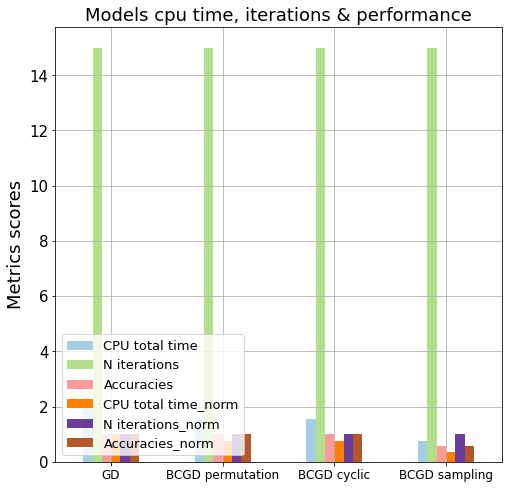

In [44]:
bar_metrics = pd.DataFrame.from_dict(cpu_times_total, orient='index', columns = ['CPU total time'])
bar_metrics['N iterations'] = n_iters.values()
bar_metrics['Accuracies'] = accuracies.values()

normalize_cols(bar_metrics)
plot_bar_metrics(bar_metrics)
bar_metrics.to_csv(full_dir + 'metrics res.csv')

bar_metrics.head()

## Graphics

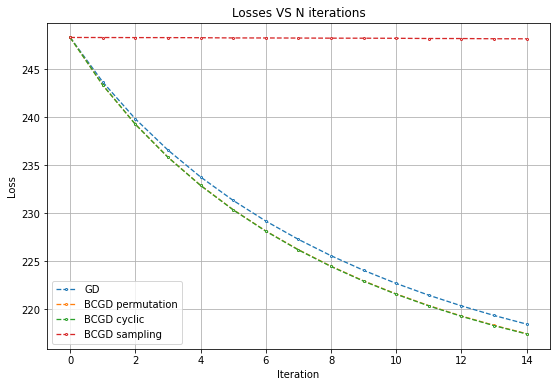

In [38]:
def plot_curves(curves_dict, title, y_label, figsize):
    _, ax = plt.subplots(figsize = figsize)

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            linestyle = '--',
            linewidth = 1.3,
            markerfacecolor = 'white',
            markersize = 2
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


# plot_curves({'Cyclic':losses['BCGD cyclic']}, 'Losses cyclic', y_label = 'Loss')
# plot_curves({'GD':losses['GD']}, 'Losses GD', y_label = 'Loss')
plot_curves(
    losses,
    'Losses VS N iterations', 
    y_label = 'Loss',
    figsize = (9, 6)
)

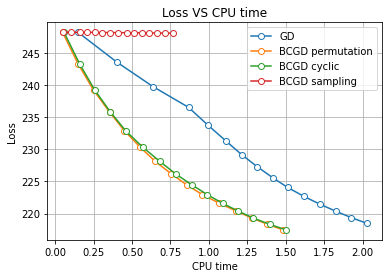

In [39]:
def plot_losses_vs_cpu(losses_, cpu_times_):
    assert(list(losses_.keys()) == list(cpu_times_.keys()))

    _, ax = plt.subplots()

    for model_name, loss in losses_.items():
        cpu_time = cpu_times_[model_name]

        ax.plot(
            cpu_time,
            loss,
            marker = 'o',
            markerfacecolor = 'white'
        )
    plt.xlabel('CPU time')
    plt.ylabel('Loss')
    plt.title('Loss VS CPU time')
    plt.legend(list(losses_.keys()))
    plt.grid()


plot_losses_vs_cpu(losses, cpu_times)


# Real dataset

In [ ]:
# df = pd.read_csv('Pokemon.csv')

In [ ]:
# df.head()

,number,name,type1,type2,total,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,3,Gigantamax Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


In [ ]:
# df.head()
# X_real = df.loc[:, ['total', 'sp_attack']].values
# Y_real = df['legendary'].astype('int').values


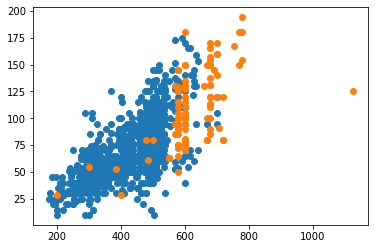

In [ ]:
# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# Y_real_delabeled = delabel_data(
#     Y_real,
#     labeled_percent = 0.16, # DataProperties.labeled_percentage,
#     delabel_value = DataProperties.unlabeled
# )

Found 954 instances of object 0
We have to delabel 801 instances
Found 118 instances of object 1
We have to delabel 99 instances


In [ ]:
# wine=datasets.load_wine()

# #Conver to pandas dataframe
# data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

# data = data.loc[
#     (data['target'] == 1) | (data['target'] == 0),
#     ['od280/od315_of_diluted_wines', 'alcohol', 'target']
# ]

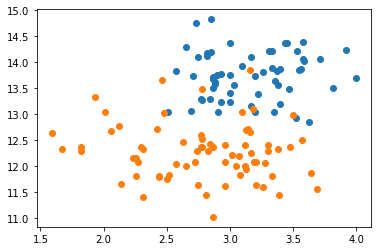

In [ ]:
# X_real = data.loc[
#     :,
#     ['od280/od315_of_diluted_wines', 'alcohol']
# ].values
# Y_real = data['target'].values

# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# solver = GradientDescentSolver(
#     lr_strategy = 'lr_constant',
#     learning_rate = 0.0001,
#     similarity_func = None
# )

# Y_real_preds = solver.solve(
#     X_real,
#     Y_real_delabeled,
#     iter_limit=5,
#     delta_loss_limit = 0.003,
#     stop_loss = 20
# )

Iteration: 0, Loss: 24173.807351957803, delta loss: 24173.807351957803
Iteration: 1, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 2, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 3, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 4, Loss: 24173.807351957803, delta loss: 0.0


